In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [2]:
import scipy.stats

In [3]:
import uproot
uproot.default_library = "np"

# Truthing

In [4]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])

In [5]:
B_features = [
    "B_plus_TRUEPT",
    "B_plus_TRUEP_X",
    "B_plus_TRUEP_Y",
]
features = B_features + [
    "e_minus_PIDe",
    "e_plus_PIDe",
    "e_minus_TRUEPT",
    "e_minus_PIDmu",
    "e_plus_PIDmu",
    "e_plus_TRUEPT",
    "q",
]

In [6]:
# https://arxiv.org/abs/2103.11769
aliases = {"q": "J_psi_1S_M", "q2": "J_psi_1S_M**2*1e-6"}
q_nr_selector = join_and("q2 > 1.1", "q2 < 6.0")
q_e_selector = join_and("q2 > 6.0", "q2 < 12.96")
q_mu_selector = join_and("q2 > 8.68", "q2 < 10.09")
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_nr_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)

# example
Jmu_selector

'((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2 > 8.68)&(q2 < 10.09))'

In [7]:
selectors = [Je_selector, Jmu_selector, Kee_selector, Kmumu_selector]

In [8]:
raw_names = [
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    "data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    "data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
]

In [9]:
raw_files = [uproot.open(name) for name in raw_names]

In [10]:
raw_b = [f.arrays(B_features, B_selector, library="np") for f in raw_files]

In [11]:
truthed = [f.arrays(features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

In [12]:
df_index = [r"$B \to KJ/\psi(\to ee)$", r"$B \to KJ/\psi(\to\mu\mu)$", r"$B \to Kee$", r"$B \to K\mu\mu$"]
df = pd.DataFrame(index=df_index)

In [13]:
df["Total"] = [f["e_minus_PIDe"].array(library="np").shape[0] for f in raw_files]
df["B"] = [b[B_features[0]].shape[0] for b in raw_b]
df["Decays"] = [b["e_minus_PIDe"].shape[0] for b in truthed]
df

Total        B   Decays
$B \to KJ/\psi(\to ee)$     2084124  1375525   696573
$B \to KJ/\psi(\to\mu\mu)$  3206889  2924782  1459292
$B \to Kee$                  413741   264461    40094
$B \to K\mu\mu$              665455   563948    72469

### Some graphs

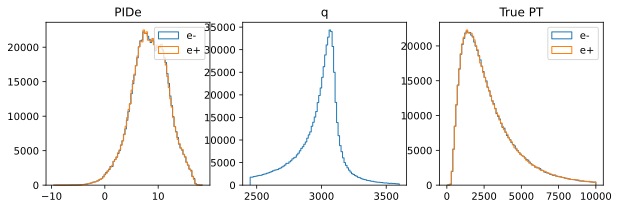

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(truthed[0]["e_minus_PIDe"], bins=100, histtype="step", label="e-")
ax[0].hist(truthed[0]["e_plus_PIDe"], bins=100, histtype="step", label="e+")
ax[0].legend()
ax[0].set_title("PIDe")
ax[1].hist(truthed[0]["q"], bins=100, histtype="step")
ax[1].set_title("q")
ax[2].hist(truthed[0]["e_minus_TRUEPT"], bins=np.linspace(0,10000,101), histtype="step", label="e-")
ax[2].hist(truthed[0]["e_plus_TRUEPT"], bins=np.linspace(0,10000,101), histtype="step", label="e+")
ax[2].legend()
ax[2].set_title("True PT")
plt.show()

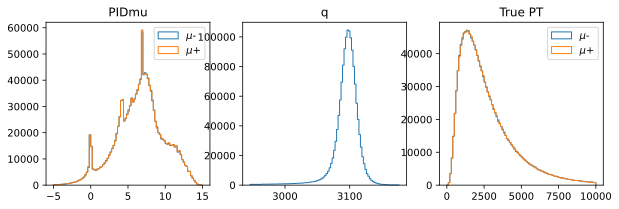

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(truthed[1]["e_minus_PIDmu"], bins=np.linspace(-5,15,101), histtype="step", label=r"$\mu$-")
ax[0].hist(truthed[1]["e_plus_PIDmu"], bins=np.linspace(-5,15,101), histtype="step", label=r"$\mu$+")
ax[0].legend()
ax[0].set_title("PIDmu")
ax[1].hist(truthed[1]["q"], bins=100, histtype="step")
ax[1].set_title("q")
ax[2].hist(truthed[1]["e_minus_TRUEPT"], bins=np.linspace(0,10000,101), histtype="step", label=r"$\mu$-")
ax[2].hist(truthed[1]["e_plus_TRUEPT"], bins=np.linspace(0,10000,101), histtype="step", label=r"$\mu$+")
ax[2].legend()
ax[2].set_title("True PT")
plt.show()

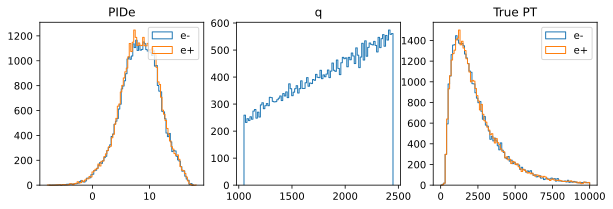

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(truthed[2]["e_minus_PIDe"], bins=100, histtype="step", label="e-")
ax[0].hist(truthed[2]["e_plus_PIDe"], bins=100, histtype="step", label="e+")
ax[0].legend()
ax[0].set_title("PIDe")
ax[1].hist(truthed[2]["q"], bins=100, histtype="step")
ax[1].set_title("q")
ax[2].hist(truthed[2]["e_minus_TRUEPT"], bins=np.linspace(0,10000,101), histtype="step", label="e-")
ax[2].hist(truthed[2]["e_plus_TRUEPT"], bins=np.linspace(0,10000,101), histtype="step", label="e+")
ax[2].legend()
ax[2].set_title("True PT")
plt.show()

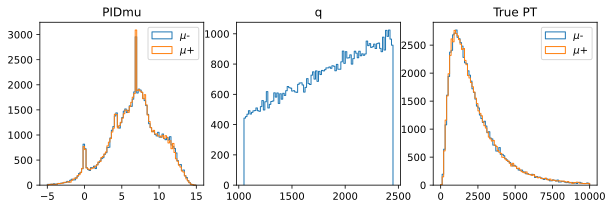

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(truthed[3]["e_minus_PIDmu"], bins=np.linspace(-5,15,101), histtype="step", label=r"$\mu$-")
ax[0].hist(truthed[3]["e_plus_PIDmu"], bins=np.linspace(-5,15,101), histtype="step", label=r"$\mu$+")
ax[0].legend()
ax[0].set_title("PIDmu")
ax[1].hist(truthed[3]["q"], bins=100, histtype="step")
ax[1].set_title("q")
ax[2].hist(truthed[3]["e_minus_TRUEPT"], bins=np.linspace(0,10000,101), histtype="step", label=r"$\mu$-")
ax[2].hist(truthed[3]["e_plus_TRUEPT"], bins=np.linspace(0,10000,101), histtype="step", label=r"$\mu$+")
ax[2].legend()
ax[2].set_title("True PT")
plt.show()

# Ratios

$R_K=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)}\cdot\frac{\mathcal{B}(B\to KJ/\psi(\to ee))}{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}$.

In [18]:
df["BR"] = df["Decays"]/df["B"]
df

Total        B   Decays        BR
$B \to KJ/\psi(\to ee)$     2084124  1375525   696573  0.506405
$B \to KJ/\psi(\to\mu\mu)$  3206889  2924782  1459292  0.498940
$B \to Kee$                  413741   264461    40094  0.151606
$B \to K\mu\mu$              665455   563948    72469  0.128503

In [19]:
r_jpsi = df["BR"][1]/df["BR"][0]
r_jpsi

0.985259319946491

In [20]:
r_k = df["BR"][3]/df["BR"][2]
r_k

0.8476088009851435

In [21]:
r_k/r_jpsi

0.8602900615354512

In [22]:
(df["Decays"][3]/df["Decays"][2])/(df["Decays"][1]/df["Decays"][0])

0.8627745334620901

### GenLevel data

In [23]:
gl_names = [
    "data/sim09g_KJpsiGenLevel_2017MD.root:DecayTree;1",
    "data/sim09g_KJpsiGenLevel_mumu2017MD.root:DecayTree;1",
    "data/sim09g_KeeGenLevel_2017MD.root:DecayTree;1",
    "data/sim09g_KmumuGenLevel_2017MD.root:DecayTree;1",
]

In [24]:
gl_files = [uproot.open(name) for name in gl_names]

In [25]:
gl_B_features = ["B_plus_PX", "B_plus_PY"]
gl_B_selector = B_selector

In [26]:
gl_b = [f.arrays(gl_B_features, gl_B_selector, library="np") for f in gl_files]

In [27]:
gl_df = pd.DataFrame(index=df_index)

In [28]:
gl_df["GLTotal"] = [a["B_plus_TRUEID"].array(library="np").shape[0] for a in gl_files]
gl_df["GLB"] = [a["B_plus_PX"].shape[0] for a in gl_b]
gl_df

GLTotal      GLB
$B \to KJ/\psi(\to ee)$     3536685  3536684
$B \to KJ/\psi(\to\mu\mu)$  3728928  3728928
$B \to Kee$                 1003132  1003131
$B \to K\mu\mu$             1002574  1002574

### GenLevel graphs

In [29]:
def plot_b_stats(data, weights=None):
    px = data["B_plus_PX"]
    py = data["B_plus_PY"]
    fig, ax = plt.subplots(1, 3, figsize=(10,3))
    ax[0].hist(px, histtype="step", label=r"px", bins=np.linspace(-10000, 10000, 101), density=True, weights=weights)
    ax[0].hist(py, histtype="step", label=r"py", bins=np.linspace(-10000, 10000, 101), density=True, weights=weights)
    ax[0].legend()
    ax[0].set_title("B+ P")
    ax[1].hist(np.arctan2(py, px), histtype="step", bins=51, density=True, cumulative=False, weights=weights)
    ax[1].set_title("B+ P angle")
    #ax[2].scatter(px, py)
    ax[2].hist2d(px, py, range=[[-5000, 5000],[-5000, 5000]], bins=(21,21), weights=weights)
    ax[2].set_title("B+ P XY plane")
    ax[2].grid(False)
    plt.show()

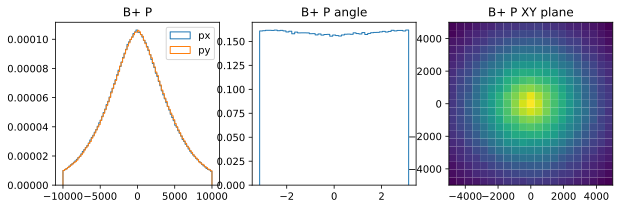

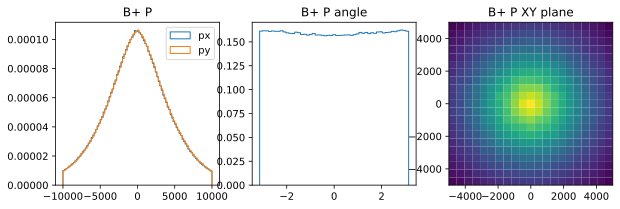

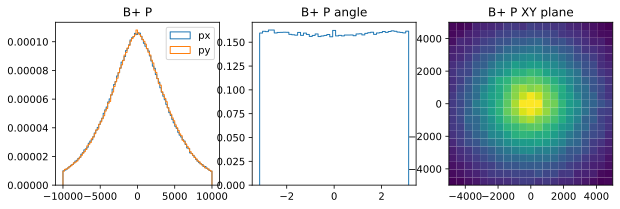

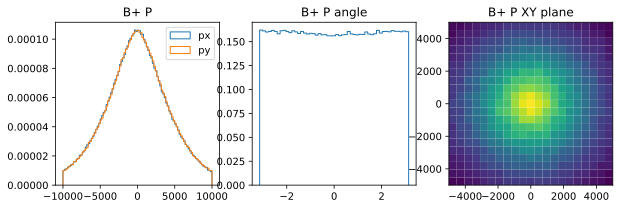

In [30]:
for b in gl_b:
    plot_b_stats(b)

### Kolmogorov-Smirnov test for angle

In [31]:
def angle(a):
    return np.arctan2(a["B_plus_PY"], a["B_plus_PX"])

In [32]:
gl_b_angles = [angle(a) for a in gl_b]

In [33]:
def cdf(x): return np.minimum(1, np.maximum(0, x/(2*np.pi)+0.5))
ks_stats = [scipy.stats.kstest(a, cdf) for a in gl_b_angles]

In [34]:
gl_df["GLKS"] = [s.statistic for s in ks_stats]
gl_df["GLKS pv"] = [s.pvalue for s in ks_stats]
gl_df

GLTotal      GLB      GLKS       GLKS pv
$B \to KJ/\psi(\to ee)$     3536685  3536684  0.002746  1.362311e-23
$B \to KJ/\psi(\to\mu\mu)$  3728928  3728928  0.002389  6.488109e-19
$B \to Kee$                 1003132  1003131  0.002399  1.935759e-05
$B \to K\mu\mu$             1002574  1002574  0.002617  2.173705e-06

In [35]:
scipy.stats.kstest(gl_b_angles[0], gl_b_angles[1])

KstestResult(statistic=0.0008492668348334398, pvalue=0.14570840698645782)

In [36]:
scipy.stats.kstest(gl_b_angles[2], gl_b_angles[3])

KstestResult(statistic=0.0017480681402396447, pvalue=0.09324009176926262)

### Reweigting

In [37]:
def weight(data):
    x = data["B_plus_PX"]
    y = data["B_plus_PY"]
    t = np.hypot(x, y)
    return 1 + 0.1 * x/t

In [38]:
gl_b_weights = [weight(a) for a in gl_b]

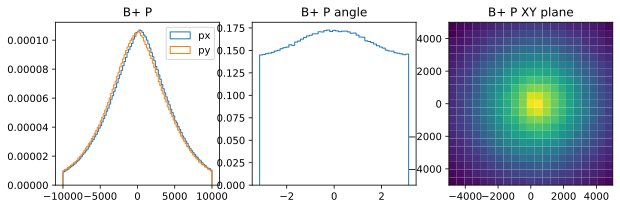

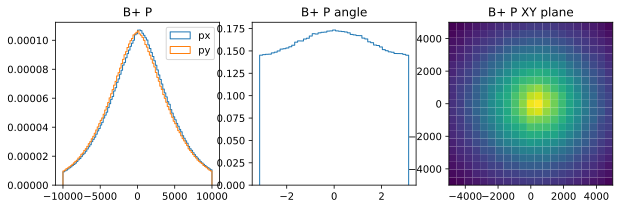

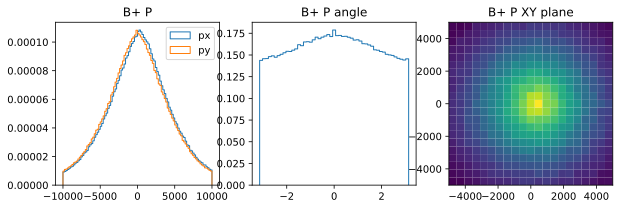

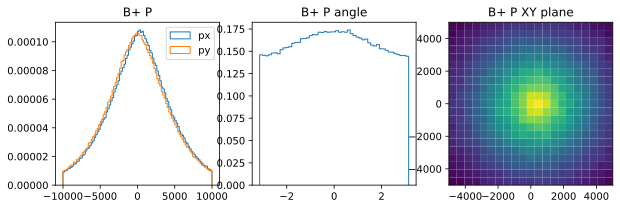

In [39]:
for b, w in zip(gl_b, gl_b_weights):
    plot_b_stats(b, weights=w)

In [40]:
gl_df["wB"] = [np.sum(w) for w in gl_b_weights]
gl_df["wB/B"] = [np.mean(w) for w in gl_b_weights]
gl_df

GLTotal      GLB      GLKS       GLKS pv  \
$B \to KJ/\psi(\to ee)$     3536685  3536684  0.002746  1.362311e-23   
$B \to KJ/\psi(\to\mu\mu)$  3728928  3728928  0.002389  6.488109e-19   
$B \to Kee$                 1003132  1003131  0.002399  1.935759e-05   
$B \to K\mu\mu$             1002574  1002574  0.002617  2.173705e-06   

                                      wB      wB/B  
$B \to KJ/\psi(\to ee)$     3.533978e+06  0.999235  
$B \to KJ/\psi(\to\mu\mu)$  3.726194e+06  0.999267  
$B \to Kee$                 1.002488e+06  0.999359  
$B \to K\mu\mu$             1.001925e+06  0.999353

### Reweighting RK

In [41]:
def weight_raw(data):
    x = data["B_plus_TRUEP_X"]
    y = data["B_plus_TRUEP_Y"]
    t = np.hypot(x, y)
    return 1 + 0.1 * x/t

In [42]:
raw_b_weights = [weight_raw(a) for a in raw_b]

In [43]:
truthed_weights = [weight_raw(a) for a in truthed]

In [44]:
df["wB"] = [np.sum(b) for b in raw_b_weights]
df["wDecays"] = [np.sum(b) for b in truthed_weights]
df["wBR"] = df["wDecays"]/df["wB"]
df

Total        B   Decays        BR            wB  \
$B \to KJ/\psi(\to ee)$     2084124  1375525   696573  0.506405  1.376129e+06   
$B \to KJ/\psi(\to\mu\mu)$  3206889  2924782  1459292  0.498940  2.924600e+06   
$B \to Kee$                  413741   264461    40094  0.151606  2.646734e+05   
$B \to K\mu\mu$              665455   563948    72469  0.128503  5.639097e+05   

                                 wDecays       wBR  
$B \to KJ/\psi(\to ee)$     6.968596e+05  0.506391  
$B \to KJ/\psi(\to\mu\mu)$  1.459190e+06  0.498936  
$B \to Kee$                 4.012605e+04  0.151606  
$B \to K\mu\mu$             7.244717e+04  0.128473

In [45]:
rw_jpsi = df["wBR"][1]/df["wBR"][0]
rw_k = df["wBR"][3]/df["wBR"][2]
rw_K = rw_k/rw_jpsi
rw_K

0.8600755450703056